In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, r2_score
import math
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load data
data = pd.read_csv("RELIANCE.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Date', 'Close']].dropna()
data = data.sort_values('Date')

In [6]:
# Prepare log returns for volatility
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data['RealizedVol'] = data['LogReturn'].rolling(window=5).apply(lambda x: np.sqrt(np.mean(x**2)))

In [7]:
# Rename for Prophet
df = data[['Date', 'Close']].rename(columns={"Date": "ds", "Close": "y"})

In [8]:
# Metric collectors
mae_list, rmse_list = [], []
acc_list, f1_list = [], []
actual_prices, predicted_prices = [], []
true_dirs, pred_dirs = [], []
actual_vols, predicted_vols = [], []

rolling_days = 30
start_index = len(df) - rolling_days - 1

In [9]:
for i in range(start_index, len(df) - 1):
    train = df[:i]  # up to current day

    # Train Prophet
    model = Prophet(daily_seasonality=True)
    model.fit(train)

    # Make prediction for next day
    future = model.make_future_dataframe(periods=1)
    forecast = model.predict(future)
    
    pred_price = forecast['yhat'].iloc[-1]
    actual_price = df['y'].iloc[i + 1]
    current_price = df['y'].iloc[i]

    # Store price prediction metrics
    actual_prices.append(actual_price)
    predicted_prices.append(pred_price)
    mae_list.append(mean_absolute_error([actual_price], [pred_price]))
    rmse_list.append(math.sqrt(mean_squared_error([actual_price], [pred_price])))

    # Direction metrics
    true_dir = int(actual_price > current_price)
    pred_dir = int(pred_price > current_price)
    true_dirs.append(true_dir)
    pred_dirs.append(pred_dir)
    acc_list.append(accuracy_score([true_dir], [pred_dir]))
    f1_list.append(f1_score([true_dir], [pred_dir], zero_division=1))

    # Volatility (naive)
    actual_vol = data['RealizedVol'].iloc[i + 1]
    predicted_vol = data['RealizedVol'].iloc[i]
    if np.isnan(actual_vol) or np.isnan(predicted_vol):
        continue
    actual_vols.append(actual_vol)
    predicted_vols.append(predicted_vol)

15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:32 - cmdstanpy - INFO - Chain [1] done processing
15:22:32 - cmdstanpy - INFO - Chain [1] start processing
15:22:34 - cmdstanpy - INFO - Chain [1] done processing
15:22:35 - cmdstanpy - INFO - Chain [1] start processing
15:22:36 - cmdstanpy - INFO - Chain [1] done processing
15:22:37 - cmdstanpy - INFO - Chain [1] start processing
15:22:39 - cmdstanpy - INFO - Chain [1] done processing
15:22:40 - cmdstanpy - INFO - Chain [1] start processing
15:22:41 - cmdstanpy - INFO - Chain [1] done processing
15:22:42 - cmdstanpy - INFO - Chain [1] start processing
15:22:43 - cmdstanpy - INFO - Chain [1] done processing
15:22:44 - cmdstanpy - INFO - Chain [1] start processing
15:22:46 - cmdstanpy - INFO - Chain [1] done processing
15:22:47 - cmdstanpy - INFO - Chain [1] start processing
15:22:49 - cmdstanpy - INFO - Chain [1] done processing
15:22:49 - cmdstanpy - INFO - Chain [1] start processing
15:22:51 - cmdstanpy - INFO - Chain [1]

In [14]:
# Final volatility R² and RMSE
vol_rmse = math.sqrt(mean_squared_error(actual_vols, predicted_vols))
vol_r2 = r2_score(actual_vols, predicted_vols)

In [15]:
print(" Prophet Rolling Evaluation Summary:\n")
print(f" Price Prediction: MAE = {np.mean(mae_list):.4f}, RMSE = {np.mean(rmse_list):.4f}")
print(f" Direction Prediction: Accuracy = {np.mean(acc_list):.4f}, F1 = {np.mean(f1_list):.4f}")
print(f" Volatility Prediction: RMSE = {vol_rmse:.6f}, R² = {vol_r2:.4f}")

 Prophet Rolling Evaluation Summary:

 Price Prediction: MAE = 210.6119, RMSE = 210.6119
 Direction Prediction: Accuracy = 0.5333, F1 = 0.5333
 Volatility Prediction: RMSE = 0.003104, R² = 0.5190


## Visualisation

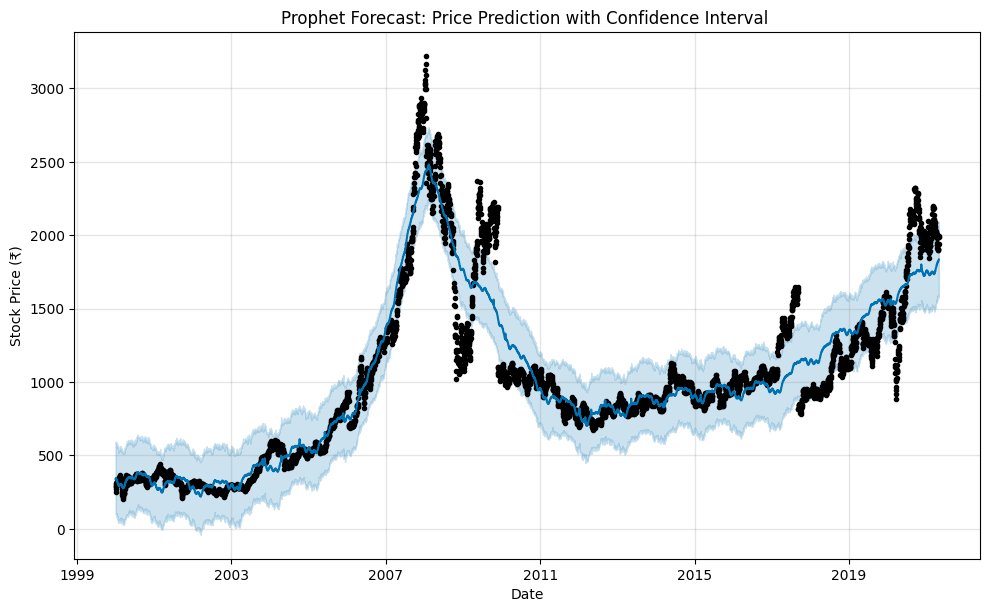

In [25]:
# Full Forecast with Confidence Intervals
model.plot(forecast)
plt.title("Prophet Forecast: Price Prediction with Confidence Interval ")
plt.xlabel("Date")
plt.ylabel("Stock Price (₹)")
plt.show()

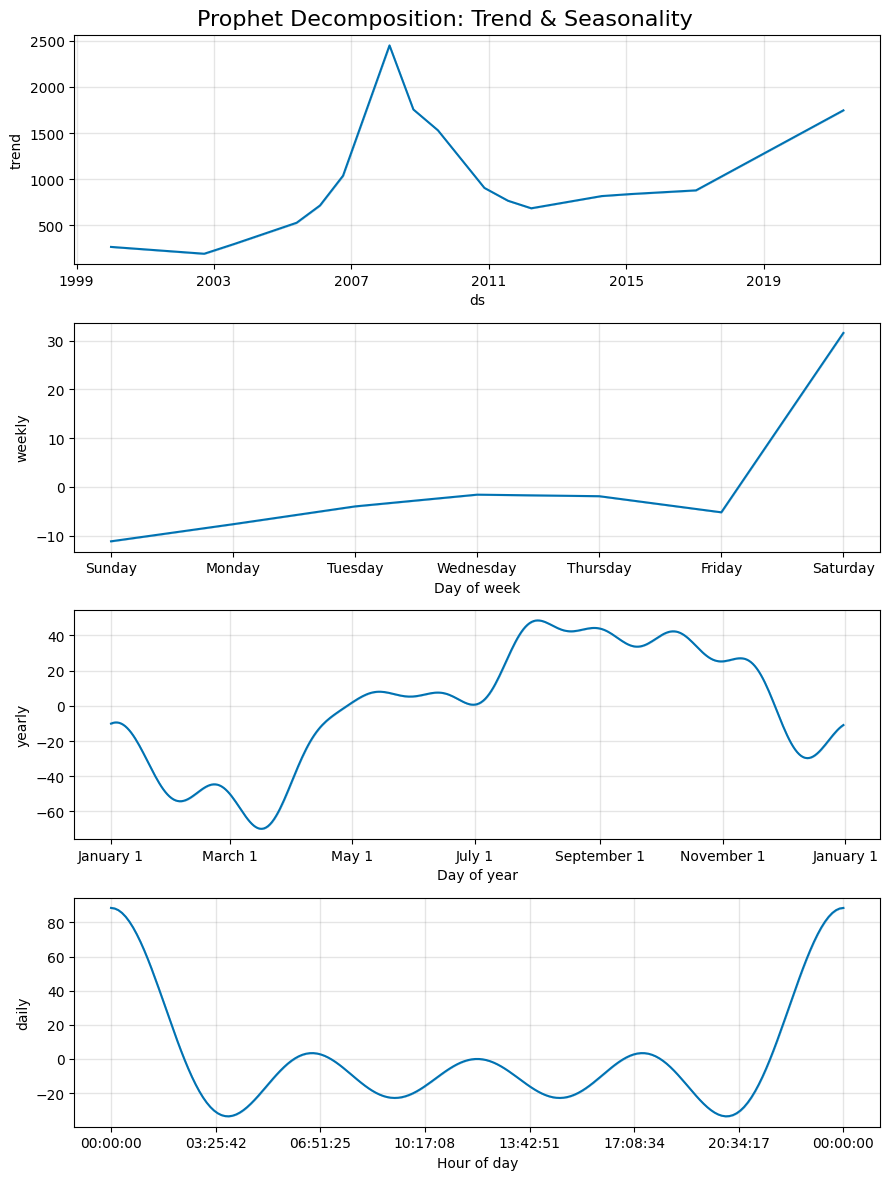

In [24]:
#Trend + Seasonality Components
model.plot_components(forecast)
plt.suptitle("Prophet Decomposition: Trend & Seasonality", fontsize=16)
plt.tight_layout()
plt.show()

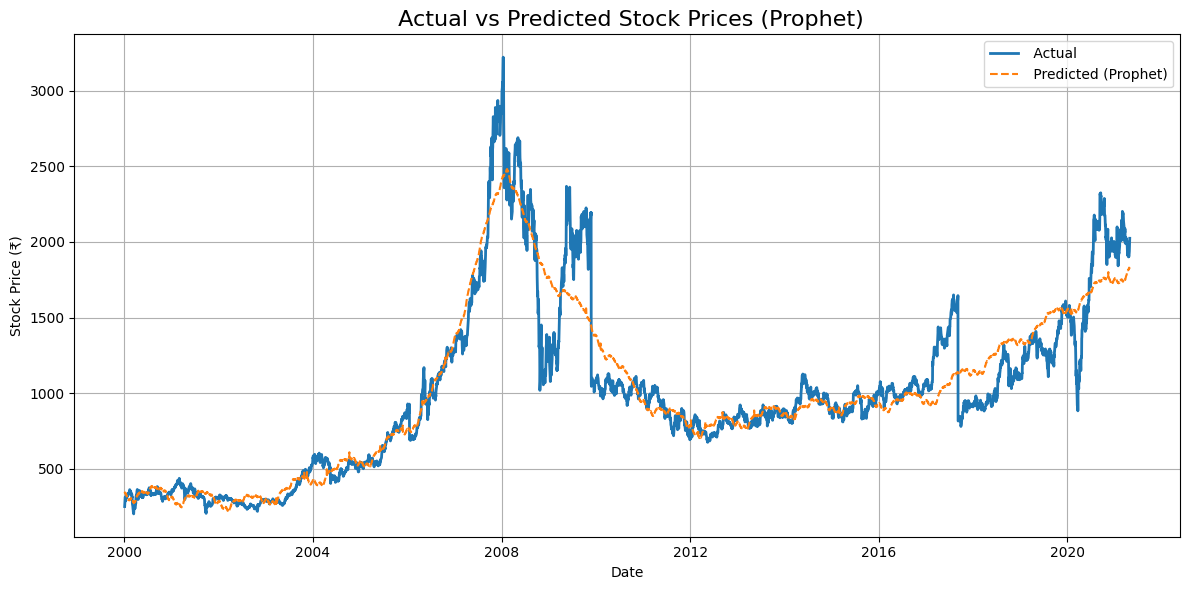

In [22]:
#Actual vs Predicted Prices 
# Merge actual data with forecast
df_plot = df.copy()
df_plot = df_plot.rename(columns={"y": "Actual"})
forecast_trim = forecast.set_index("ds")[["yhat"]].rename(columns={"yhat": "Predicted"})
combined = df_plot.set_index("ds").join(forecast_trim, how="inner")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(combined.index, combined["Actual"], label=" Actual", linewidth=2)
plt.plot(combined.index, combined["Predicted"], label=" Predicted (Prophet)", linestyle='--')
plt.title(" Actual vs Predicted Stock Prices (Prophet)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Stock Price (₹)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

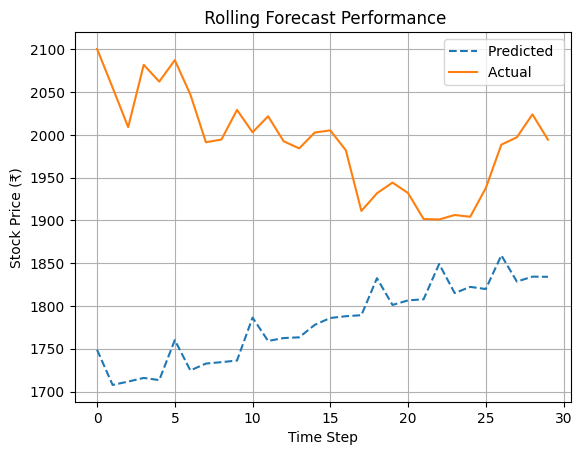

In [23]:
# After the loop
plt.plot(predicted_prices, label="Predicted ", linestyle="--")
plt.plot(actual_prices, label="Actual ")
plt.title(" Rolling Forecast Performance")
plt.xlabel("Time Step")
plt.ylabel("Stock Price (₹)")
plt.legend()
plt.grid()
plt.show()